In [10]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', 100)  
from joblib import dump, load
import os
import statsmodels.formula.api as smf
import statsmodels.api as sm
import string  # for data prep


# visualizations
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = [6, 8]
plt.rcParams['figure.dpi'] = 200
from sklearn.metrics import plot_confusion_matrix

# modeling helper functions
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV

#### Load Data

In [11]:
# Please Download Data from Repository
raw_train_data_Y = pd.read_csv('https://raw.githubusercontent.com/mvenouziou/Capstone_Projects/main/train_labels_water_table.csv')
raw_train_data_X = pd.read_csv('https://raw.githubusercontent.com/mvenouziou/Capstone_Projects/main/train_values_water_table.csv')

#raw_train_data_Y = pd.read_csv('datasets/train_values_water_table.csv')
#raw_train_data_Y = pd.read_csv('datasets/train_labels_water_table.csv')

In [13]:
"""
# if using Google Drive to load dataset:

from google.colab import drive
drive.mount('/content/drive')

with open('/content/drive/My Drive/Colab Notebooks/datasets/train_values_water_table.csv', 'r') as f:
    raw_train_data_X = pd.read_csv(f)

with open('/content/drive/My Drive/Colab Notebooks/datasets/train_labels_water_table.csv', 'r') as f:
    raw_train_data_Y = pd.read_csv(f)
"""

"\n# if using Google Drive to load dataset:\n\nfrom google.colab import drive\ndrive.mount('/content/drive')\n\nwith open('/content/drive/My Drive/Colab Notebooks/datasets/train_values_water_table.csv', 'r') as f:\n    raw_train_data_X = pd.read_csv(f)\n\nwith open('/content/drive/My Drive/Colab Notebooks/datasets/train_labels_water_table.csv', 'r') as f:\n    raw_train_data_Y = pd.read_csv(f)\n"

In [14]:
raw_train_data_X.head(1)

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,recorded_by,scheme_management,scheme_name,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
0,69572,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,0,Lake Nyasa,Mnyusi B,Iringa,11,5,Ludewa,Mundindi,109,True,GeoData Consultants Ltd,VWC,Roman,False,1999,gravity,gravity,gravity,vwc,user-group,pay annually,annually,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe


### Define Data Prep Functions

In [15]:
def data_shaper(df, test_data=False):
    """
    Data processing step to prepare data features. 
    Makes updates that are independent of train / test/ valid split.
    """

    dataframe = df.copy()
   
    # restrict to data from 2011 - 2013
    if not test_data:
        year_mask = restrict_year(dataframe) 
        dataframe = dataframe[year_mask]    
    
    # consolidate 'unknown' and NaN values
    dataframe = dataframe.replace(['unknown'], np.nan)
    
    # Convert target labels to numerical encoding.
    # not used with official DrivenData (unlabelled) training set
    # functional = 2, needs repair = 1, non functional = 0
    try:
        dataframe['status_group'] = dataframe['status_group'].replace(
            ['functional', 'functional needs repair', 'non functional'],
            [2, 1, 0])
    except:
        pass

    # Numerical Features: 
    # Extract observation year from 'date recorded'
    dataframe['date_recorded_year'] = \
        pd.to_datetime(dataframe['date_recorded']).dt.year
    
    # Prepare numeric features and standardize missing values
    for feat in ['amount_tsh', 'construction_year', 'date_recorded_year',
                 'gps_height', 'population']:      
        dataframe[feat] = pd.to_numeric(dataframe[feat])
        dataframe[feat] = dataframe[feat].replace([0, None], np.nan)
    dataframe = dataframe.rename(columns={'amount_tsh': 'water_pressure_amount_tsh'})
    
    # New features: 'pump age' and 'log(1 + pump age)'
    # age, (exclude dates where pump construction later than recorded date)
    dataframe['age'] = \
        np.where(dataframe['construction_year'] > dataframe['date_recorded_year'], np.nan,
        dataframe['date_recorded_year'] - dataframe['construction_year'])
    # log age
    dataframe['age (log scaled)'] = np.log(1 + dataframe['age'])
    
    # Convert binary categorical data to numeric
    for feat in ['public_meeting', 'permit']:
        dataframe[feat] = dataframe[feat].replace([True, False, None],
                                                      [1, 0, np.nan])
        dataframe[feat] = pd.to_numeric(dataframe[feat])
        
        # Rename columns for clarity
        dataframe = dataframe.rename(columns={feat: feat + ' (y/n)'})
    
    # Categorical Features:     
    
    # Specify as categorical type and replace nan with 'Other'
    categs = list(dataframe.select_dtypes(exclude='number').columns)

    for feat in categs:
        dataframe[feat] = dataframe[feat].replace([np.nan, '0', None, 'unknown'], 
                                                  'other')#.astype('category')
    
    # Consolidate similar values such as 'comm' and 'community'
    for feat in ['funder', 'installer']:
        
        # identify value names needing to be changed
        changes_a = []
        changes_b = []
        for name in list(dataframe[feat].unique()):
            if 'Comm' in str(name):  # all values including 'Comm'
                changes_a.append(name)
            elif 'gov' in str(name).lower():  # all values including 'gov'
                changes_b.append(name)
        
        # implement name changes
        dataframe[feat] = dataframe[feat].replace(changes_a,'Community')
        dataframe[feat] = dataframe[feat].replace(changes_b,'Government')
       
    # rename values for clarity / consolidation
    dataframe['payment'] = \
        dataframe['payment'].replace({'never pay': 'None', 
                                      'pay annually': 'per period', 
                                      'pay monthly': 'per period',
                                      'pay per bucket': 'per use',
                                      'pay when scheme fails': 'upon failure'})
   
    # Drop unneeded or duplicative features
    # identify unwanted features
    drop_columns = ['id', 'wpt_name', 'num_private', 
                    'date_recorded', 'date_recorded_year', 
                    'construction_year', 'longitude', 'latitude',
                    'region_code', 'district_code', 'lga', 
                    'recorded_by', 'scheme_management', 'scheme_name', 
                    'extraction_type_group', 'extraction_type','management', 
                    'payment_type', 'quality_group', 'quantity_group', 
                    'source_type', 'source_class', 'waterpoint_type_group',
                    'date_recorded_year', 'date_recorded_month', 
                    'date_recorded_day']

                 # The 'optional' variables:
                 # ['age', 'basin', 'gps_height', 'population', 'water_pressure_amount_tsh' \
                 # + 'region', 'management_group', 'funder', 'ward', 
                 # 'subvillage', 'installer', 'payment']
    
    # identify features to keep
    keep_columns = set(dataframe.columns).difference(set(drop_columns))
    
    # restrict data to desires features
    dataframe = dataframe[list(keep_columns)]                           
    
    return dataframe

In [16]:
def preproc_stage_1(X, y, target, random_state_seed, feature_values=None, 
                    known_means=None, fill_missing=True, drop_nan=False):
    """
    Prepares data for model
    
    Parameters:
    X: DataFrame of features
    y: DataFrame containing target labels
    target: string, name of target variable in y
    random_state_seed: integer, required for consistent test/train/validation splits. 
                       Make sure this is consistent across entire program!
    feature_values: dictionary, controls how some categorical variables are binned
    known_means: DataFrame consisting of feature columns and only one row, 
                 containing training set means (or other value to be used for filling NaN)
    fill_missing: boolean, determines if NaN values are filled
    drop_nan: boolean, determines if NaN values are dropped
    """
    
    # merge features and target labels
    try:
        df = pd.concat([X, y[[target]]], axis='columns')
    except:
        df = X.copy()
    
    # drop NaN values (optional)
    if drop_nan:
        df = df.dropna()
    
    # Run first data prep function. Makes updates 
    # that are independent of train / test/ valid split
    if y is None:
        using_test_data = True
    else:
        using_test_data = False
    df = data_shaper(df, using_test_data)

    # Next: data prep that requires knowledge of the training set
    # Extract training data
    training_df, _ = split_data(df, random_state_seed)

    # get values for filling missing data
    # generate the data if values were not passed in via 'fill_means'
    if known_means is None:
        fill_means = training_df.mean()  # .median()
    else:
        fill_means = known_means
    
    # exclude target values to make sure they remain unaltered
    # note: target may not be present (example: official unlabelled test set)
    try:  
        fill_means.pop(target)  
    except:  
        pass
    
    # fill missing data in full dataset using means generated from training data
    if fill_missing:
        df = fillnans(df, fill_means)
    
    # collapse categorical variables with too many unique values
    # extract categorical features
    categ_features_df = training_df.select_dtypes(exclude='number')
    
    # Set binning criteria if not already passed in via 'feature_values'
    if feature_values is None:
        # set criteria for how many unique values a feature needs for us to bin it
        cutoff = 10
        
        # create container for holding bin sizes
        feature_values = dict()
        
        for feat in categ_features_df.columns:
            values = training_df[feat].value_counts().sort_values()
            
            # check that feature needs to be binned
            if len(values) > cutoff:

                # generate info for binning feature
                feature_values[feat] = dict()

                # define bin limits
                arr = values.to_numpy()
                cut_1 = np.percentile(arr, 100/6)
                cut_2 = np.percentile(arr, 200/6) 
                cut_3 = np.percentile(arr, 300/6) 
                cut_4 = np.percentile(arr, 400/6) 
                cut_5 = np.percentile(arr, 500/6) 
                               
                # save info                                  
                feature_values[feat]['cut_1'] = cut_1
                feature_values[feat]['cut_2'] = cut_2
                feature_values[feat]['cut_3'] = cut_3
                feature_values[feat]['cut_4'] = cut_4          
                feature_values[feat]['cut_5'] = cut_5   
    
    # Bin data from full dataset as specified by 'feature_values'
    for feat in feature_values.keys():
        values = df[feat].value_counts().sort_values()
        
        # unpack bin limits
        cut_1 = feature_values[feat]['cut_1']
        cut_2 = feature_values[feat]['cut_2']
        cut_3 = feature_values[feat]['cut_3']
        cut_4 = feature_values[feat]['cut_4']
        cut_5 = feature_values[feat]['cut_5']

        # create bins
        bin_0 = values[values <= cut_1].index
        bin_1 = values[(values > cut_1) & (values <= cut_2)].index
        bin_2 = values[(values > cut_2) & (values <= cut_3)].index
        bin_3 = values[(values > cut_3) & (values <= cut_4)].index
        bin_4 = values[(values > cut_4) & (values <= cut_5)].index
        bin_5 = values[values > cut_5].index

        # group values into bins by replacing values with bin number
        replace_val = 0
        for bin in [bin_0, bin_1, bin_2, bin_3, bin_4, bin_5]:
            
            df[feat] = df[feat].replace(to_replace=list(bin), 
                                        value=replace_val)
            # advance replacement value for next bin 
            replace_val += 1

        # declare as an (ordered) categorical variable
        df[feat] = df[feat].astype('category')
   
    # Next we create one-hot-columns based on training set values
    # Make sure target values are not affected! 
    # Split off target values (and add them back in at end)
    try:
        target_df = df.pop(target)
    except:
        pass
    
    # Propogate previous changes to the training set
    training_df, _ = split_data(df, random_state_seed)
    
    # generate one-hot-columns on training set
    training_df_hot = pd.get_dummies(training_df, dummy_na=True)
    features = training_df_hot.columns
    
    # apply one-hot-columns to the full data set
    # Match features to training set. (Needed for use in model)
    df_hot = pd.get_dummies(df, dummy_na=True)
    # add any missing features
    for feat in features:
        if feat not in df_hot.columns:
            df_hot[feat] = 0
    # remove any extra features
    df_hot = df_hot[features]  
     
   
    # add back in the target labels and convert names for clarity
    try:
        df = pd.concat([df, target_df], axis='columns') 
        df_hot = pd.concat([df_hot, target_df], axis='columns')
        
        df['status_group'] = df['status_group'].replace(
            [2, 1, 0], ['functional', 'needs repair', 'non functional'])     
        df_hot['status_group'] = df_hot['status_group'].replace(
            [2, 1, 0], ['functional', 'needs repair', 'non functional'])
        
    except:
        pass
    
    # Propogate changes to training sets
    training_df_hot, _ = split_data(df_hot, random_state_seed)
    training_df, _ = split_data(df, random_state_seed)                     
            
    return df_hot, feature_values, fill_means, training_df_hot, training_df

In [17]:
# Test / Train / Valid Split
def split_data(df, random_state_seed=None):
    train, valid = train_test_split(df, test_size=0.2, 
                                    random_state=random_state_seed)
        
    return train, valid

In [18]:
# Helper functions 
def fillnans(df, fill_values):
    """
    Fills NaN with specified values
    """   
    dataset = df.copy()
    
    for feat in fill_values.index:
        filler = fill_values[feat]
        dataset[feat] = dataset[feat].fillna(filler)
        
    return dataset


def restrict_year(df, drop_missing_years=False):
    """
    # Restricts dataset by observation year
    """
        
    # extract year recorded
    temp_df = pd.to_datetime(df['date_recorded']).dt.year
    
    # restrict year
    mask_1 = (temp_df >= 2011)
    mask = mask_1
    
    if drop_missing_years:
        mask_2 = (df['construction_year']!= 0)
        mask = mask_1 & mask_2
        
    return mask

In [19]:
#### Preprocessing Submission Data
def prepare_submission_set(features_values, means, chosen_features, random_state_seed):
    data = pd.read_csv('datasets/test_set_water_table.csv')
    
    # shape features / one-hot-encoding
    data_hot, _, _, _, _ = \
        preproc_stage_1(X=data,y=None, target='status_group', random_state_seed=random_state_seed,
                        feature_values=features_values, known_means = means,
                        fill_missing=True, drop_nan=False)       
        
    # correct for any missing one-hot-features
    current_feat = set(data_hot.columns)
    missing_feat = set(chosen_features).difference(current_feat)
    
    for feat in missing_feat:
        data_hot[feat] = 0
    data_hot = data_hot[chosen_features]
    
    return data_hot


In [20]:
def create_submission(filename, model):
    predictions = model.predict(official_test_set_hot)
    predictions_df = pd.concat([official_test_set_unprocessed['id'], 
                                pd.DataFrame({'status_group':predictions})], 
                               axis = 'columns')
    predictions_df['status_group'] = \
        predictions_df['status_group'].replace([2, 1, 0, 'needs repair'], 
                                               ['functional', 'functional needs repair', 
                                                'non functional', 'functional needs repair'])

    model_dict = dict()
    model_dict['model'] = model
    model_dict['train_X'] = train_X
    model_dict['train_y'] = train_y
    model_dict['valid_X'] = train_X
    model_dict['valid_y'] = train_y
    model_dict['test_X'] = train_X
    model_dict['test_y'] = train_y
    model_dict['official_test_set_hot'] = official_test_set_hot
    model_dict['train_set_not_hot'] = training_df

    # save model
    name = 'submission_' + filename
    dump(model_dict, name + '.joblib') 
    predictions_df.to_csv(name + '.csv' ,index=False)

### Create / Load Dataset

In [21]:
# To create dataset from scratch
# """

# set random seed for consistent test/train splits
random_state_seed = np.random.randint(10e6)

# load data
raw_train_data_Y = pd.read_csv('https://raw.githubusercontent.com/mvenouziou/Capstone_Projects/main/train_labels_water_table.csv')
raw_train_data_X = pd.read_csv('https://raw.githubusercontent.com/mvenouziou/Capstone_Projects/main/train_values_water_table.csv')
#raw_train_data_Y = pd.read_csv('datasets/train_values_water_table.csv')
#raw_train_data_Y = pd.read_csv('datasets/train_labels_water_table.csv')


#### PREPROCESSING STAGE 1
# Prepare training dataframe

df_hot, feature_values_dict, means_dict, train_df_hot, training_df  = \
     preproc_stage_1(raw_train_data_X, 
                     raw_train_data_Y, 
                     target='status_group', 
                     random_state_seed=random_state_seed,
                     feature_values=None,
                     known_means=None,
                     fill_missing=True,
                     drop_nan=True
                    )
print('Stage 1 Completed')

#### PREPROCESSING STAGE 2
# Create all datasets
train_X, valid_X = split_data(df_hot, random_state_seed)
train_y = train_X.pop('status_group')
valid_y = valid_X.pop('status_group')

print('Stage 2 Completed')

# """

Stage 1 Completed
Stage 2 Completed


In [22]:
"""
#### STAGE 3: Prepare Test Set (official for generating submission)
official_test_set_unprocessed = pd.read_csv('datasets/test_set_water_table.csv')
official_test_set_hot = \
  prepare_submission_set(feature_values_dict, means_dict, 
                         train_X.columns, random_state_seed)

print('Stage 3 Completed')
"""

"\n#### STAGE 3: Prepare Test Set (official for generating submission)\nofficial_test_set_unprocessed = pd.read_csv('datasets/test_set_water_table.csv')\nofficial_test_set_hot =   prepare_submission_set(feature_values_dict, means_dict, \n                         train_X.columns, random_state_seed)\n\nprint('Stage 3 Completed')\n"

In [23]:
# To load saved variables / model
"""
model_dict = load('datasets/prepared_data_2.joblib')

#model_dict['model'] = model
training_df = model_dict['train_set_not_hot']
train_X = model_dict['train_X']
train_y = model_dict['train_y']
train_X = model_dict['valid_X']
train_y = model_dict['valid_y']
train_X = model_dict['test_X']
train_y = model_dict['test_y']
official_test_set_hot = model_dict['official_test_set_hot']
"""

"\nmodel_dict = load('datasets/prepared_data_2.joblib')\n\n#model_dict['model'] = model\ntraining_df = model_dict['train_set_not_hot']\ntrain_X = model_dict['train_X']\ntrain_y = model_dict['train_y']\ntrain_X = model_dict['valid_X']\ntrain_y = model_dict['valid_y']\ntrain_X = model_dict['test_X']\ntrain_y = model_dict['test_y']\nofficial_test_set_hot = model_dict['official_test_set_hot']\n"

#### Prelimenary Analysis via Logistic Regression

Examining a logistic regression with quantitative and binary features we may be surprised to find that, while all have low p-values, the features “population”, “water pressure” and “GPS height” have very small coefficients. Perhaps the large number of missing data (filled with mean value) interfere with their influence. 

 “Age” should be one of the most predictive factors involved with pump status, therefore I generated this variable along with its logarithm, log(age + 1), for use in the models. More than 30% of age-related data is missing, however, and much of its predictive power has been diminished. 


In [25]:
print('Quantitative and Binary Variables\n')

temp_data = training_df.copy()
# Represent 'status_group' as quantitative between 0 and 1
temp_data['status_group'] = temp_data['status_group'].replace(
    ['functional', 'needs repair', 'non functional'],
    [1, .5, 0])

model = smf.logit('status_group ~ age + Q("age (log scaled)") \
                   + population + water_pressure_amount_tsh + gps_height \
                   + Q("permit (y/n)") + Q("public_meeting (y/n)")', 
                  data=temp_data)
model = model.fit()
model.summary()

Quantitative and Binary Variables

Optimization terminated successfully.
         Current function value: 0.620564
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:           status_group   No. Observations:                22244
Model:                          Logit   Df Residuals:                    22236
Method:                           MLE   Df Model:                            7
Date:                Tue, 08 Dec 2020   Pseudo R-squ.:                 0.06756
Time:                        22:46:40   Log-Likelihood:                -13804.
converged:                       True   LL-Null:                       -14804.
Covariance Type:            nonrobust   LLR p-value:                     0.000
=============================================================================================
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept                     0.1275      0.088      1.447      0.148      -0.045       0.300
age                          -0.0479      0.003    -14.419      0.000      -0.054      -0.041
Q("age (log scaled)")         0.0350      0.047      0.744      0.457      -0.057       0.127
population                   -0.0001   3.97e-05     -2.706      0.007      -0.000   -2.97e-05
water_pressure_amount_tsh   2.21e-05   7.85e-06      2.817      0.005    6.73e-06    3.75e-05
gps_height                    0.0005   2.88e-05     15.965      0.000       0.000       0.001
Q("permit (y/n)")             0.3290      0.035      9.449      0.000       0.261       0.397
Q("public_meeting (y/n)")     0.3047      0.056      5.403      0.000       0.194       0.415
=============================================================================================
"""

A second logistic regression, now with the categorical variables, shows all of them to be influential. Water Source, water pricing, extraction type, water quantity, water quality, water point type and basin also exhibit large variability in frequency bar graphs. 

Only two features available to us relate to ongoing maintenance: water pricing and maintenance organization. Because of this special status, both were included as core model features. 


In [26]:
print('Categorical Variables: Management and Pump Age\n')

# Represent 'status_group' as quantitative
# Represent 'status_group' as quantitative between 0 and 1
temp_data = training_df.copy()
temp_data['status_group'] = temp_data['status_group'].replace(
    ['functional', 'needs repair', 'non functional'],
    [1, .5, 0])

model = smf.logit('status_group ~ payment + management_group + Q("age (log scaled)")', 
                  data=temp_data)
model = model.fit()
model.summary()

Categorical Variables: Management and Pump Age

Optimization terminated successfully.
         Current function value: 0.598189
         Iterations 5


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:           status_group   No. Observations:                22244
Model:                          Logit   Df Residuals:                    22235
Method:                           MLE   Df Model:                            8
Date:                Tue, 08 Dec 2020   Pseudo R-squ.:                  0.1012
Time:                        22:46:40   Log-Likelihood:                -13306.
converged:                       True   LL-Null:                       -14804.
Covariance Type:            nonrobust   LLR p-value:                     0.000
==================================================================================================
                                     coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
Intercept                          0.8906      0.074     12.078      0.000       0.746       1.035
payment[T.other]                  -0.1230      0.054     -2.287      0.022      -0.228      -0.018
payment[T.per period]              1.2618      0.037     33.666      0.000       1.188       1.335
payment[T.per use]                 0.9156      0.040     22.809      0.000       0.837       0.994
payment[T.upon failure]            1.0839      0.078     13.936      0.000       0.931       1.236
management_group[T.other]          0.2147      0.149      1.440      0.150      -0.077       0.507
management_group[T.parastatal]     0.6135      0.127      4.821      0.000       0.364       0.863
management_group[T.user-group]     0.4239      0.057      7.439      0.000       0.312       0.536
Q("age (log scaled)")             -0.5515      0.019    -29.235      0.000      -0.588      -0.515
==================================================================================================
"""

#### Prelimemary Analysis via Charting

There are potential confounding factors related to changes in Tanzania’s political environment. Some pumps under consideration were constructed as early as the 1960’s, around the time the nation was formed through emancipation from the British colonial system and the merger of Tanganyika and Zanzibar. 

Since that time there have been major fluctuations in political structures, international aid and economic challenges (Britannica, 2020) which may have had an effect on maintenance and construction of basic infrastructure such as water supply


Count of Missing Age data: 20709



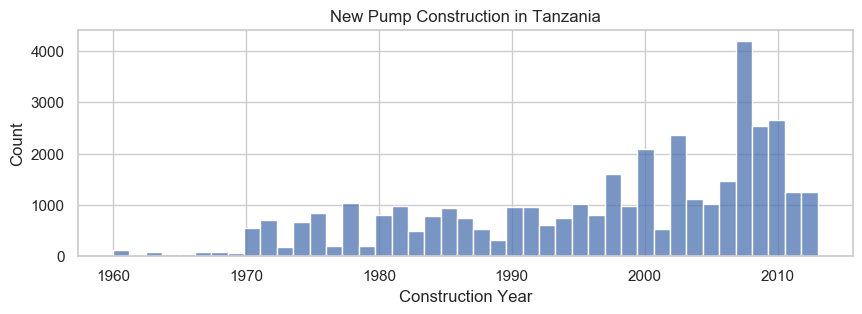

In [45]:
sns.histplot(x="construction_year", data=raw_train_data_X[raw_train_data_X['construction_year']>0])\
            .set(title='New Pump Construction in Tanzania',
                xlabel='Construction Year')
print('Count of Missing Age data:', len(raw_train_data_X[raw_train_data_X['construction_year']==0]))
print('')


[Text(0.5, 0, 'Age'), Text(0.5, 1.0, 'Distribution of Pump Ages')]

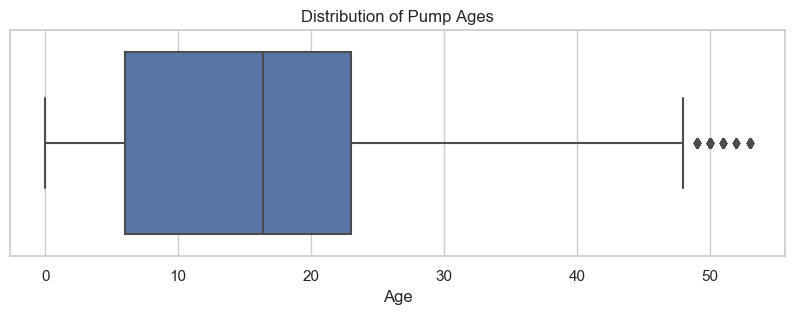

In [46]:
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = [10, 3]
plt.rcParams['figure.dpi'] = 100

sns.boxplot(x="age", data=training_df).set(
    title='Distribution of Pump Ages',
                xlabel='Age')


Requiring people to pay for water use appears highly associated with a pump’s operating status, even after controlling for age. Policy makers may consider implementing some payment structure, albeit at a low enough rate so as not to burden the populace.

Requiring Payment is Associated with Better Pump Function Status


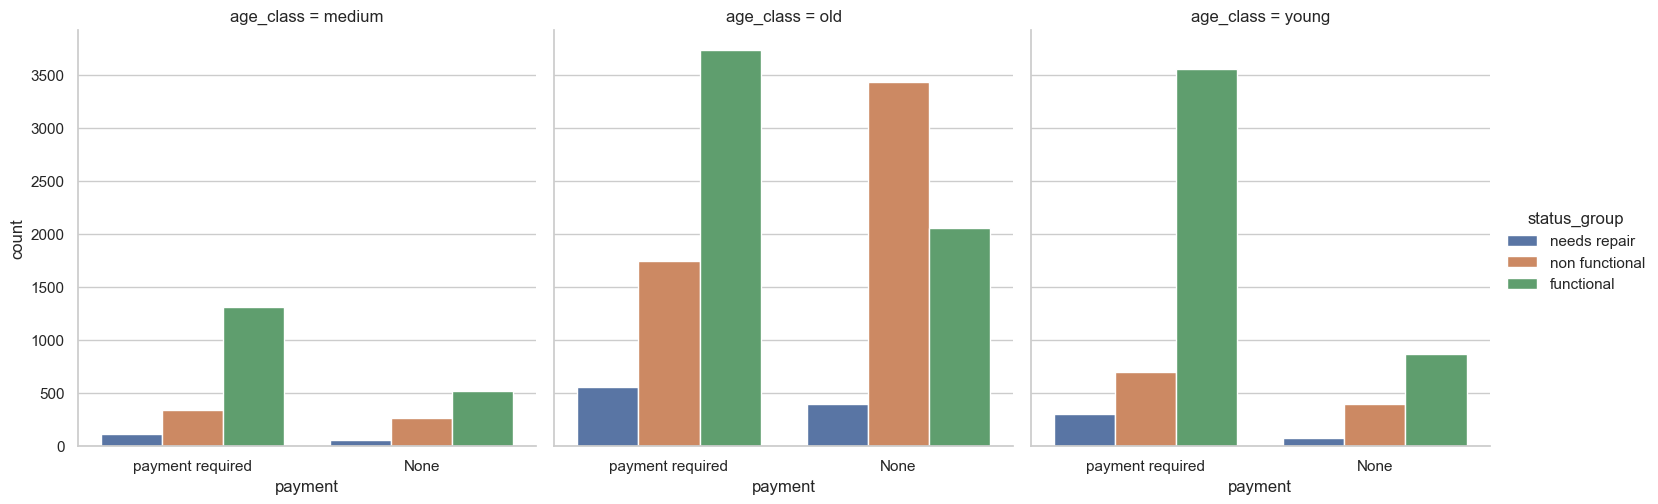

In [51]:
feat = 'payment'
print('Requiring Payment is Associated with Better Pump Function Status')
temp_data = training_df.copy()

# bin ages into three groups
over_13 = temp_data[temp_data['age'] > 13]['age']
between_7_and_13 = temp_data[(temp_data['age'] > 7) & (temp_data['age'] <= 13)]['age']
under_7 = temp_data[temp_data['age'] <=7]['age']

temp_data['age'] = temp_data['age'].replace(over_13.unique().tolist(), 14)
temp_data['age'] = temp_data['age'].replace(between_7_and_13.unique().tolist(), 12)
temp_data['age'] = temp_data['age'].replace(under_7.unique().tolist(), 6)

# name the groups
temp_data['age_class'] = temp_data['age'].replace({14: 'old',
                                                   12: 'medium', 
                                                    6: 'young'})

# adjust payment categories
temp_data['payment'] = \
    temp_data['payment'].replace(['per period', 'per use', 'upon failure'],
                                  'payment required')
temp_data = temp_data[temp_data['payment'] != 'other']

# create plot
sns.catplot(data= temp_data, hue = 'status_group', x = feat, 
           col='age_class', kind="count", col_wrap=3, log=False)


### Predictive Models

Training Score: 0.8530839777018522
Validation Score: 0.8048912066175148


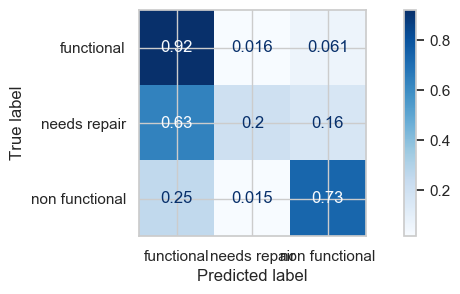

In [30]:
#"""
# NEURAL NETWORK
from sklearn.pipeline import Pipeline
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV

# model pipeline
mlp = Pipeline([('scale', StandardScaler()),
                ('mlp', MLPClassifier(hidden_layer_sizes=(100, 80, 25), 
                                       max_iter=300,
                                       early_stopping=True,
                                       alpha=.2))
                  ])
"""
# optimal paramter search
param_grid = dict(mlp__hidden_layer_sizes=[(50,80,50),
                                           (200,80,25),
                                           (100,80,25),
                                           (200),
                                           (400)]
                 )

mlp_grid = GridSearchCV(mlp, param_grid=param_grid, 
                   cv=3, n_jobs=-1, verbose=2, 
                   scoring= 'accuracy')
# Train Model
mlp_grid.fit(train_X, train_y.to_numpy().ravel())

print('')
print('best_score_:', mlp_grid.best_score_)
print('cv_results_:', mlp_grid.cv_results_)
print('best_params_:', mlp_grid.best_params_
"""

# Train Model
mlp.fit(train_X, train_y.to_numpy().ravel())

# Training Score
train_score = mlp.score(train_X, train_y.to_numpy().ravel())
print('Training Score:', train_score)

# Validation Score
valid_score = mlp.score(valid_X, valid_y.to_numpy().ravel())
print('Validation Score:', valid_score)

# confusion matrix
plot_confusion_matrix(mlp, valid_X, valid_y.to_numpy().ravel(), 
                      normalize='true', cmap=plt.cm.Blues,)
# """

Training Score: 0.8525445063837439
Validation Score: 0.8226937601150872


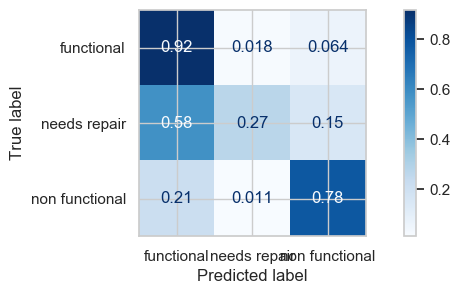

In [31]:
# Histogram Gradient Boosted Model (scikit-learn experimental)
# experimental scikit-learn ML 
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingClassifier



hbc = HistGradientBoostingClassifier(max_iter=400,
                                     #l2_regularization=.01,
                                     min_samples_leaf=250
                                    )

"""
# note: this model handles NaN values on its own. 
# Optional - Use this to adds them back in:
nan_train_x = train_X.replace('other', np.nan)  # cat variables 
nan_train_x[nan_train_x == nan_train_x.mean()] = np.nan  # quant variables

nan_valid_X = valid_X.replace('other', np.nan)
nan_valid_X[nan_valid_X == nan_valid_X.mean()] = np.nan
"""

# Train Model
hbc.fit(train_X, train_y.to_numpy().ravel())

# Training Score
train_score = hbc.score(train_X, train_y.to_numpy().ravel())#nan_train_x, train_y.to_numpy().ravel())
print('Training Score:', train_score)

# Validation Score
valid_score = hbc.score(valid_X, valid_y.to_numpy().ravel())#nan_valid_X, valid_y.to_numpy().ravel())
print('Validation Score:', valid_score)

# confusion matrix
plot_confusion_matrix(hbc, valid_X, valid_y.to_numpy().ravel(), normalize='true', cmap=plt.cm.Blues,)


Training Score: 0.7609242941916922
Validation Score: 0.7647905053048013


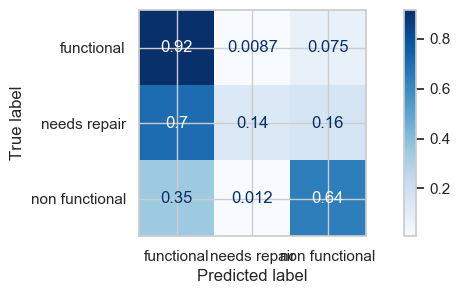

In [33]:
# Standard Decision Tree model (scikit-learn)
# Examine Ongoing Maintenance Features Only
from sklearn import tree

from sklearn.tree import DecisionTreeClassifier
dtc = DecisionTreeClassifier(max_depth=None, 
                             min_samples_leaf=100,
                             #splitter='random',
                            # class_weight='balanced'
                            )

# Train Model
dtc.fit(train_X, train_y.to_numpy().ravel())


# Train Score
train_score = dtc.score(train_X, train_y.to_numpy().ravel())
print('Training Score:', train_score)

# Validation Score
valid_score = dtc.score(valid_X, valid_y.to_numpy().ravel())#nan_valid_X, valid_y.to_numpy().ravel())
print('Validation Score:', valid_score)

# confusion matrix
plot_confusion_matrix(dtc, valid_X, valid_y.to_numpy().ravel(), normalize='true', cmap=plt.cm.Blues,)


Training Score: 0.7914493796079842
Validation Score: 0.784571120302104


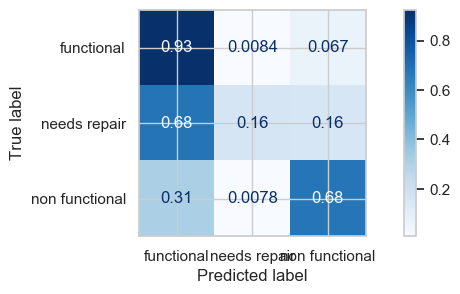

In [35]:
# GradientBoostingClassifier Model
from sklearn.ensemble import GradientBoostingClassifier

gb = GradientBoostingClassifier(n_estimators=200,
                                 #min_samples_split=50,
                                 #warm_start=True
                                )

# Train Model
gb.fit(train_X, train_y.to_numpy().ravel())

# Training Score
train_score = gb.score(train_X, train_y.to_numpy().ravel())
print('Training Score:', train_score)

# Validation Score
valid_score = gb.score(valid_X, valid_y.to_numpy().ravel())
print('Validation Score:', valid_score)

# confusion matrix
plot_confusion_matrix(gb, valid_X, valid_y, normalize='true', cmap=plt.cm.Blues,)

Training Score: 0.827324222262183
Validation Score: 0.8115446862075166


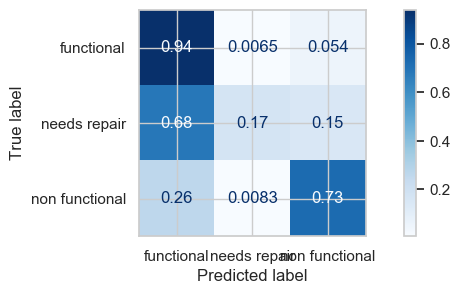

In [37]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(n_estimators=200,
                              min_samples_split=50,
                              n_jobs=-1)

# Train Model
rfc.fit(train_X, train_y.to_numpy().ravel())

# Training Score
train_score = rfc.score(train_X, train_y.to_numpy().ravel())
print('Training Score:', train_score)

# Validation Score
valid_score = rfc.score(valid_X, valid_y.to_numpy().ravel())
print('Validation Score:', valid_score)

# confusion matrix
plot_confusion_matrix(rfc, valid_X, valid_y, normalize='true', cmap=plt.cm.Blues,)

Training Score: 0.7983725948570402
Validation Score: 0.7529221363064197


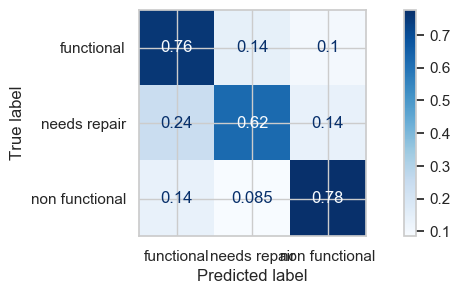

In [39]:
# Weighted Model
from sklearn.ensemble import RandomForestClassifier

num_need_repair = np.count_nonzero(train_y=='needs repair')
num_functional = np.count_nonzero(train_y=='functional')
num_non_functional = np.count_nonzero(train_y=='non functional')

balance = {'functional': 1, 
          'needs repair': num_functional/num_need_repair, 
          'non functional': num_functional/num_non_functional}

class_weights_dict = balance.copy()
class_weights_dict['needs repair']# *= 3

rfc2 = RandomForestClassifier(n_estimators=200,
                             class_weight=class_weights_dict,
                             #ccp_alpha=.00005,
                             #max_features=1.0,
                             #min_samples_leaf=3,
                             min_samples_split=50,
                             n_jobs=-1
                            )

# Train Model
rfc2.fit(train_X, train_y.to_numpy().ravel())

# Training Score
train_score = rfc2.score(train_X, train_y.to_numpy().ravel())
print('Training Score:', train_score)

# Validation Score
valid_score = rfc2.score(valid_X, valid_y.to_numpy().ravel())
print('Validation Score:', valid_score)

# confusion matrix
plot_confusion_matrix(rfc2, valid_X, valid_y, normalize='true', cmap=plt.cm.Blues,)

Training Score: 0.8331684948750224
Validation Score: 0.8138823952526524


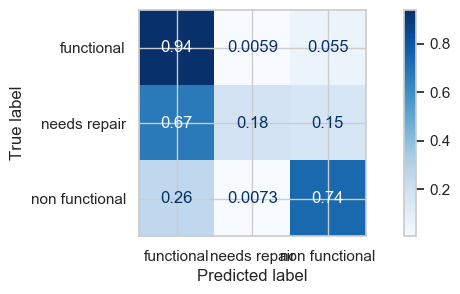

In [41]:
# Extra Trees Classifier
from sklearn.ensemble import ExtraTreesClassifier
etc = ExtraTreesClassifier(n_estimators=100,
                           min_samples_split = 50,
                           #max_features='auto',
                           #criterion='entropy',
                           #warm_start=True,
                           n_jobs= -1)

# Train Model
etc.fit(train_X, train_y.to_numpy().ravel())

# Training Score
train_score = etc.score(train_X, train_y.to_numpy().ravel())
print('Training Score:', train_score)

# Validation Score
valid_score = etc.score(valid_X, valid_y.to_numpy().ravel())
print('Validation Score:', valid_score)

# confusion matrix
plot_confusion_matrix(etc, valid_X, valid_y, normalize='true', cmap=plt.cm.Blues,)

[Voting] ...................... (1 of 3) Processing hbc, total=  11.2s
[Voting] ...................... (2 of 3) Processing rfc, total=   2.0s
[Voting] ...................... (3 of 3) Processing etc, total=   0.7s
Training Score: 0.8431936702032009
Validation Score: 0.8234130552058982


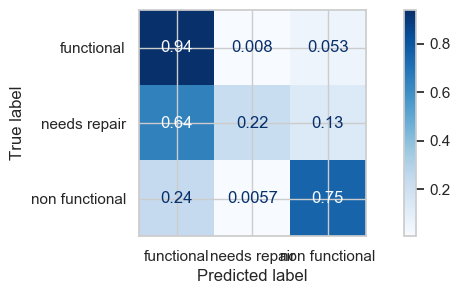

In [43]:
# Voting Ensemble Classifier (scikit-learn)
from sklearn.ensemble import VotingClassifier

eclf = VotingClassifier(estimators=[('hbc', hbc),
                                    #('dtc', dtc),
                                    #('gb', gb), 
                                    ('rfc', rfc),
                                    #('rfc2', rfc2),
                                    ('etc', etc),
                                    ],
                                     voting='soft',
                                   verbose=True)

# Train Model
eclf.fit(train_X, train_y.to_numpy().ravel())

# Training Score
train_score = eclf.score(train_X, train_y.to_numpy().ravel())
print('Training Score:', train_score)

# Validation Score
valid_score = eclf.score(valid_X, valid_y.to_numpy().ravel())
print('Validation Score:', valid_score)

# confusion matrix
plot_confusion_matrix(eclf, valid_X, valid_y, normalize='true', cmap=plt.cm.Blues,)